In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid",font_scale=1.5)

In [2]:
import lightgbm as lgb

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [6]:
train_path = "/content/train.csv"
test_path = "/content/test (1).csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [7]:
df_train

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...,...
409,409,1.011,5.21,527,21.4,75,1.53,0
410,410,1.024,5.53,577,19.7,224,0.77,0
411,411,1.018,6.28,455,22.2,270,7.68,1
412,412,1.008,7.12,325,12.6,75,1.03,1


In [8]:
df_train.shape

(414, 8)

In [9]:
df_train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [10]:
df_test.shape

(276, 7)

In [11]:
df_test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Kidney Stone Prediction based on Urine Analysis](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis) dataset. These are the descriptions of the variables in this dataset:
<ul>
    <li> id: id of the obsevation. </li>
    <li> gravity: specific gravity, the density of the urine relative to water. </li>
    <li> ph: negative logarithm of the hydrogen ion. </li>
    <li> osmo: osmolarity. Osmolarity is proportional to the concentration of
molecules in solution. </li>
    <li> cond: conductivity (mMho milliMho). One Mho is one
reciprocal Ohm. Conductivity is proportional to the concentration of charged
ions in solution. </li>
    <li> urea: urea concentration in millimoles per litre. </li>
    <li> calc: calcium
concentration (CALC) in millimolesllitre. </li>
    <li> target: 0- absence of stone 1- presence of stone. </li>
</ul>

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data preprocessing</h1>

In [12]:
df_train.head(3)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0


In [13]:
df_test.head(3)

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00


In [14]:
a=df_train.columns.tolist()

In [15]:
df_train.drop("id", inplace = True, axis = 1)
df_test.drop("id", inplace = True, axis = 1)

In [16]:
df_train

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...
409,1.011,5.21,527,21.4,75,1.53,0
410,1.024,5.53,577,19.7,224,0.77,0
411,1.018,6.28,455,22.2,270,7.68,1
412,1.008,7.12,325,12.6,75,1.03,1


### The six physical characteristics found in the dataset are:
<table border="1" cellspacing="0" cellpadding="5" style="font-size: 18px;">
  <thead>
    <tr>
      <th>Characteristic</th>
      <th>Normal Range</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Specific Gravity</td>
      <td><a href = "https://www.ucsfhealth.org/medical-tests/urine-specific-gravity-test"> 1.005 - 1.030 </a></td>
    </tr>
    <tr>
      <td>pH</td>
        <td><a href = "https://www.ucsfhealth.org/medical-tests/urine-ph-test">4.6-8.0</a></td>
    </tr>
    <tr>
      <td>Osmolarity (mOsm)</td>
      <td><a href = "https://www.gloshospitals.nhs.uk/our-services/services-we-offer/pathology/tests-and-investigations/osmolality/"> 50-1200</a> </td>
    </tr>
    <tr>
      <td>Conductivity (mMho)</td>
      <td><a href = "https://pubmed.ncbi.nlm.nih.gov/19921168/"> 1.1 - 33.9</a></td>
    </tr>
    <tr>
      <td>Urea (mmol/L)</td>
      <td><a href = "https://www.news-medical.net/health/Urine-Composition-Whats-Normal.aspx">50-127.7</a></td>
    </tr>
    <tr>
      <td>Calcium (mmol/L)</td>
        <td><a href = "https://academic.oup.com/labmed/article/41/11/683/2504912">2.2-2.6</a></td>
    </tr>
  </tbody>
</table>

In [17]:
df_train.shape

(414, 7)

In [18]:
s_temp = df_train["target"].copy()
df_train.drop("target", axis = 1, inplace = True)
df_train["train"], df_test["train"] = 1, 0
df_train["target"] = s_temp.copy()
df = pd.concat([df_train, df_test])
df

,gravity,ph,osmo,cond,urea,calc,train,target
0,1.013,6.19,443,14.8,124,1.45,1,0.0
1,1.025,5.40,703,23.6,394,4.18,1,0.0
2,1.009,6.13,371,24.5,159,9.04,1,0.0
3,1.021,4.91,442,20.8,398,6.63,1,1.0
4,1.021,5.53,874,17.8,385,2.21,1,1.0
...,...,...,...,...,...,...,...,...
271,1.029,6.27,853,21.4,364,7.31,0,NaN
272,1.012,5.62,410,14.0,195,1.45,0,NaN
273,1.031,5.68,874,29.0,380,4.49,0,NaN
274,1.019,5.47,543,21.4,170,1.64,0,NaN


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   train    414 non-null    int64  
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [20]:
df_train.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})

,Total No. of Missing Values
gravity,0
ph,0
osmo,0
cond,0
urea,0
calc,0
train,0
target,0


In [21]:
df_train.duplicated().any()

False

* There are **no duplicate records** present in the dataset.
* So we can say there is no **Data Lekage** in the dataset.

#EDA

<ipython-input-22-bb22fdda8f2a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(y=df_train["target"].value_counts().values,x=["No","Yes"],palette=["#1d7874","#8B0000"])


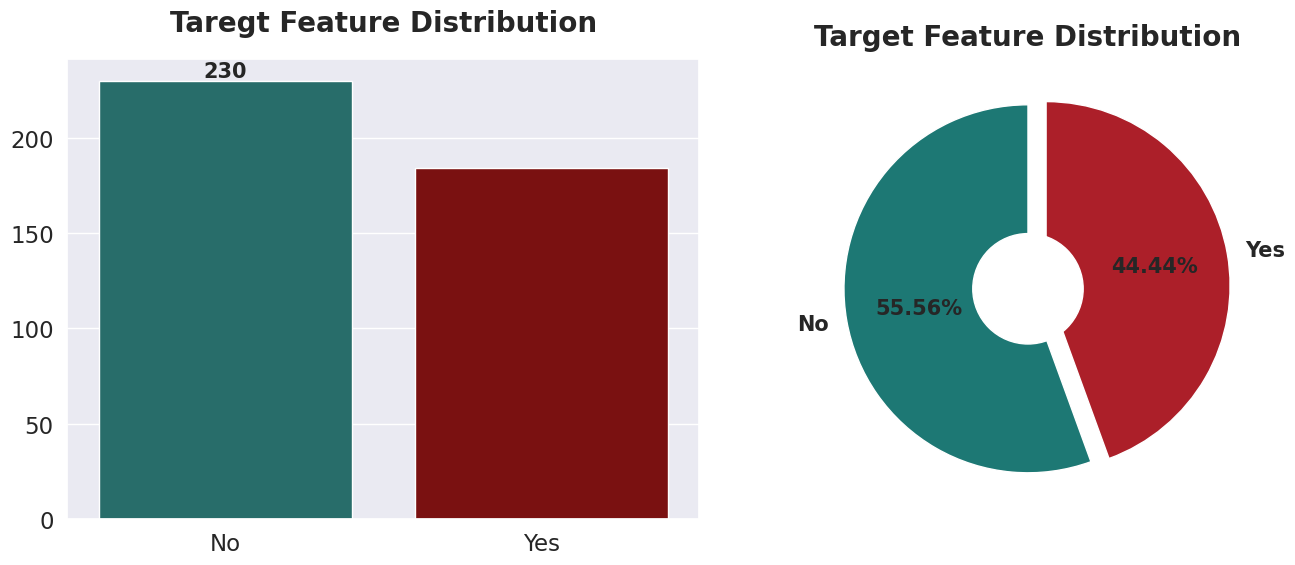

In [22]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ax=sns.barplot(y=df_train["target"].value_counts().values,x=["No","Yes"],palette=["#1d7874","#8B0000"])
plt.title("Taregt Feature Distribution",fontweight="black",size=20,pad=20)
ax.bar_label(ax.containers[0],fontweight="black",size=15)
plt.subplot(1,2,2)
plt.pie(df["target"].value_counts().values, labels=["No","Yes"], autopct="%.2f%%",
        textprops={"fontweight":"black","size":15}, colors = ["#1d7874","#AC1F29"],explode=[0,0.1],startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Target Feature Distribution",fontweight="black",size=20,pad=10)
plt.tight_layout()
plt.show()

##Distribution of all features and relation with target variables

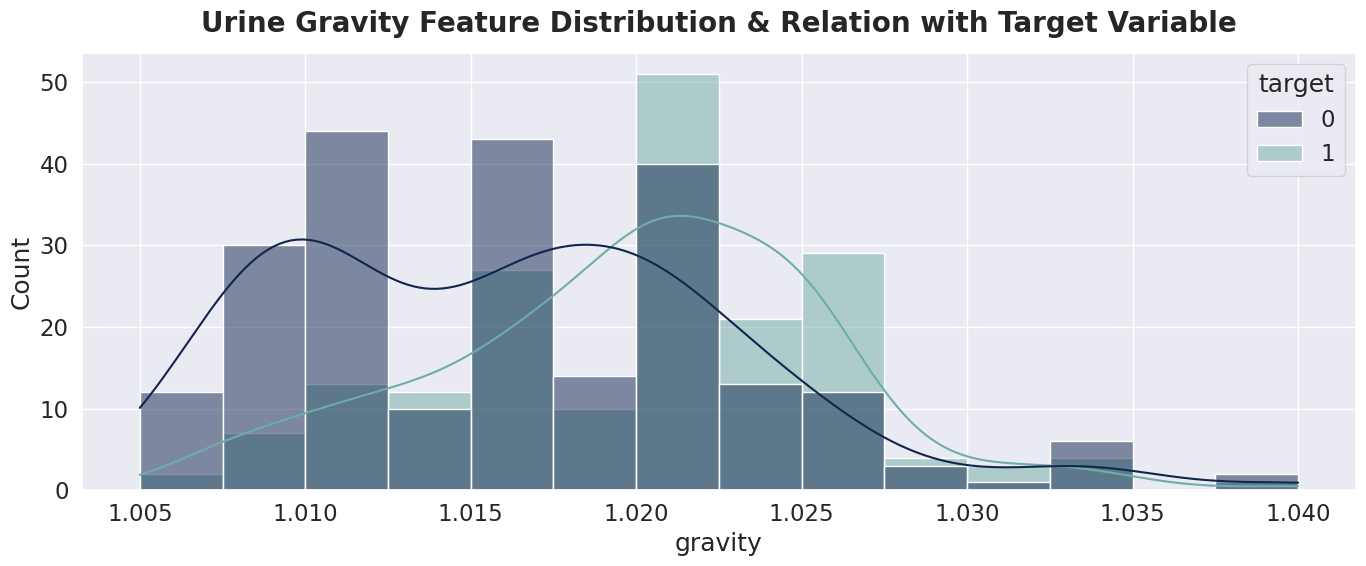

In [23]:
plt.figure(figsize=(14,6))
sns.histplot(x=df_train["gravity"], hue=df_train["target"], kde=True, palette=["#11264e", "#6faea4"])
plt.title("Urine Gravity Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
plt.tight_layout()
plt.show()


* **Most of patient having stone in their kidney** have high **Urine gravity** and vice-versa.


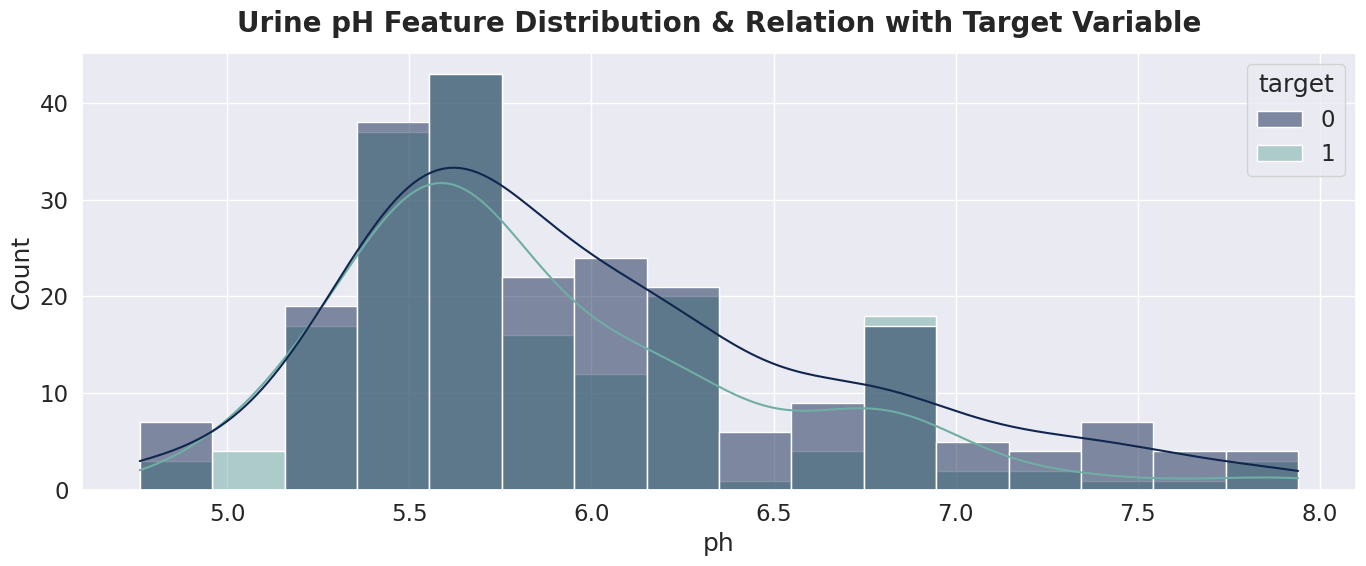

In [24]:
plt.figure(figsize=(14,6))
sns.histplot(x=df_train["ph"], hue=df_train["target"], kde=True, palette=["#11264e", "#6faea4"])
plt.title("Urine pH Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
plt.tight_layout()
plt.show()


* **Most of patient having stone in their kidney**  have **pH value very low or equal to average pH value.**

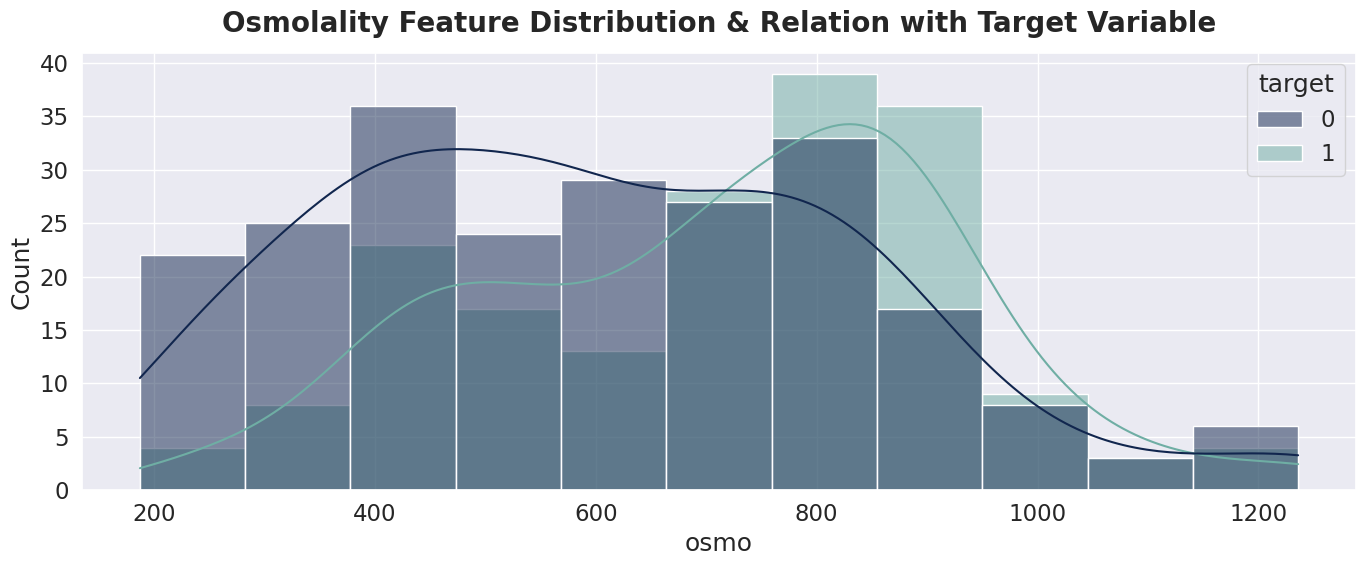

In [25]:
plt.figure(figsize=(14,6))
sns.histplot(x=df_train["osmo"], hue=df_train["target"], kde=True, palette=["#11264e", "#6faea4"])
plt.title("Osmolality Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
plt.tight_layout()
plt.show()


* **Osmolality value is very low or very high.**

* Hence, this **feature is essential for model-building.**

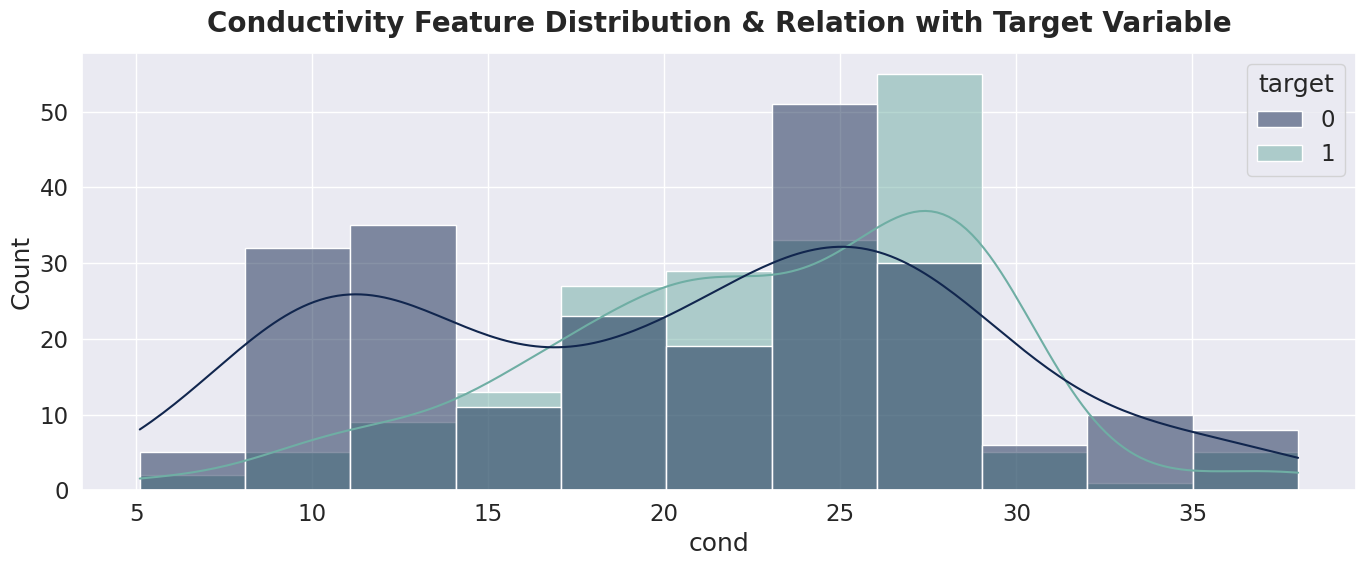

In [26]:
plt.figure(figsize=(14,6))
sns.histplot(x=df_train["cond"], hue=df_train["target"], kde=True, palette=["#11264e", "#6faea4"])
plt.title("Conductivity Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
plt.tight_layout()
plt.show()


* **Most of the patient having stone** have **an avergae conductivity (ion level) value.**



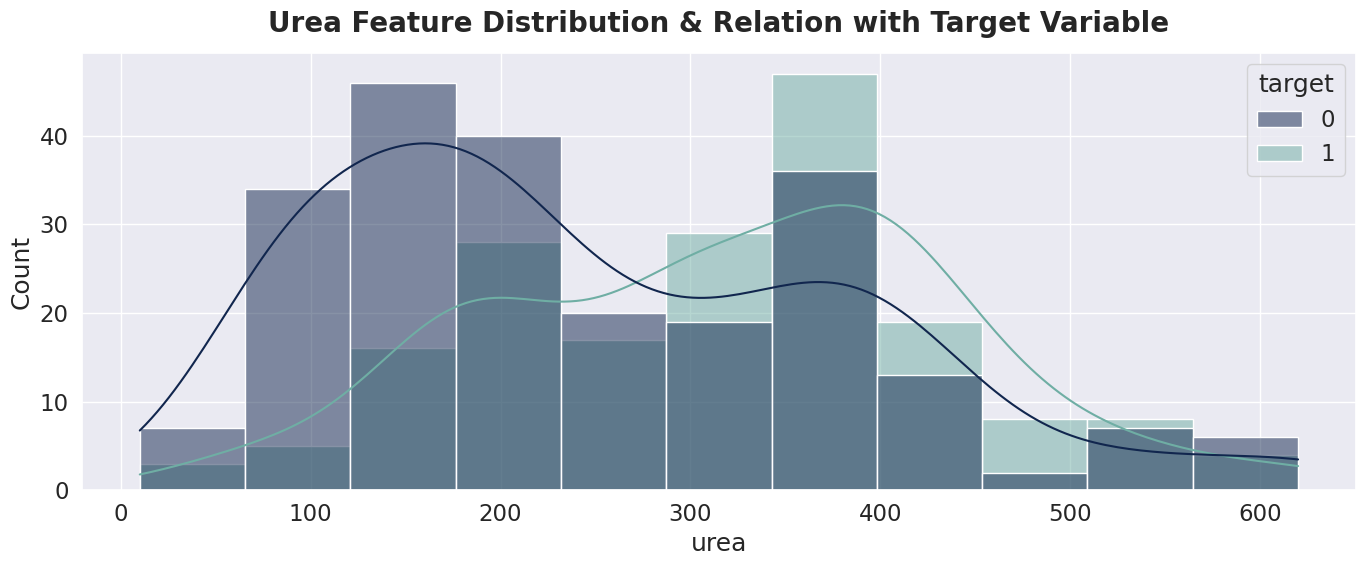

In [27]:
plt.figure(figsize=(14,6))
sns.histplot(x=df_train["urea"], hue=df_train["target"], kde=True, palette=["#11264e", "#6faea4"])
plt.title("Urea Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
plt.tight_layout()
plt.show()


* **Most of the patient having stone in their kidney** are having **high urea values.**
* But some **patient having average or low Urea values** are also suffering from this disease.


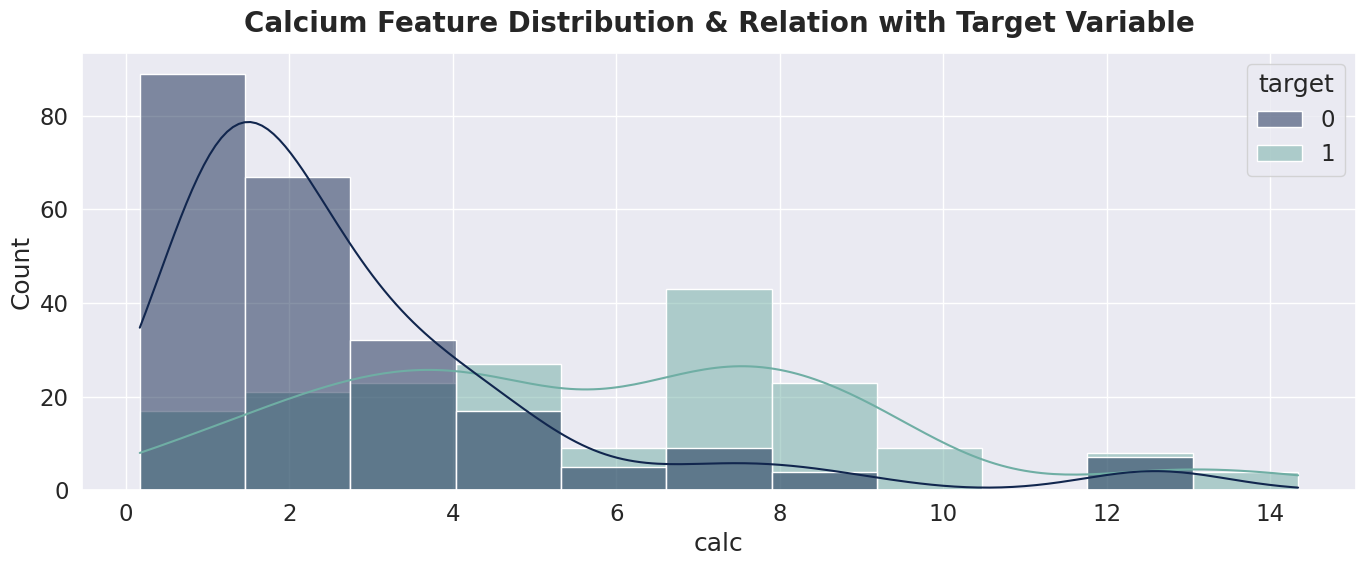

In [28]:

# Plotting
plt.figure(figsize=(14,6))
sns.histplot(x=df_train["calc"], hue=df_train["target"], kde=True, palette=["#11264e", "#6faea4"])
plt.title("Calcium Feature Distribution & Relation with Target Variable", fontweight="black", size=20, pad=15)
plt.tight_layout()
plt.show()


* **Most of the patient having stone in their kidney** are having **high calcium values.**
* so we can make an infernece that **with increase in calcium level** there is **more chance of patinet having stone in kidney.**
* Hence, this **feature is essential for model-building.**

Finidng Relation between "Urine_Gravity w.r.t Other Features

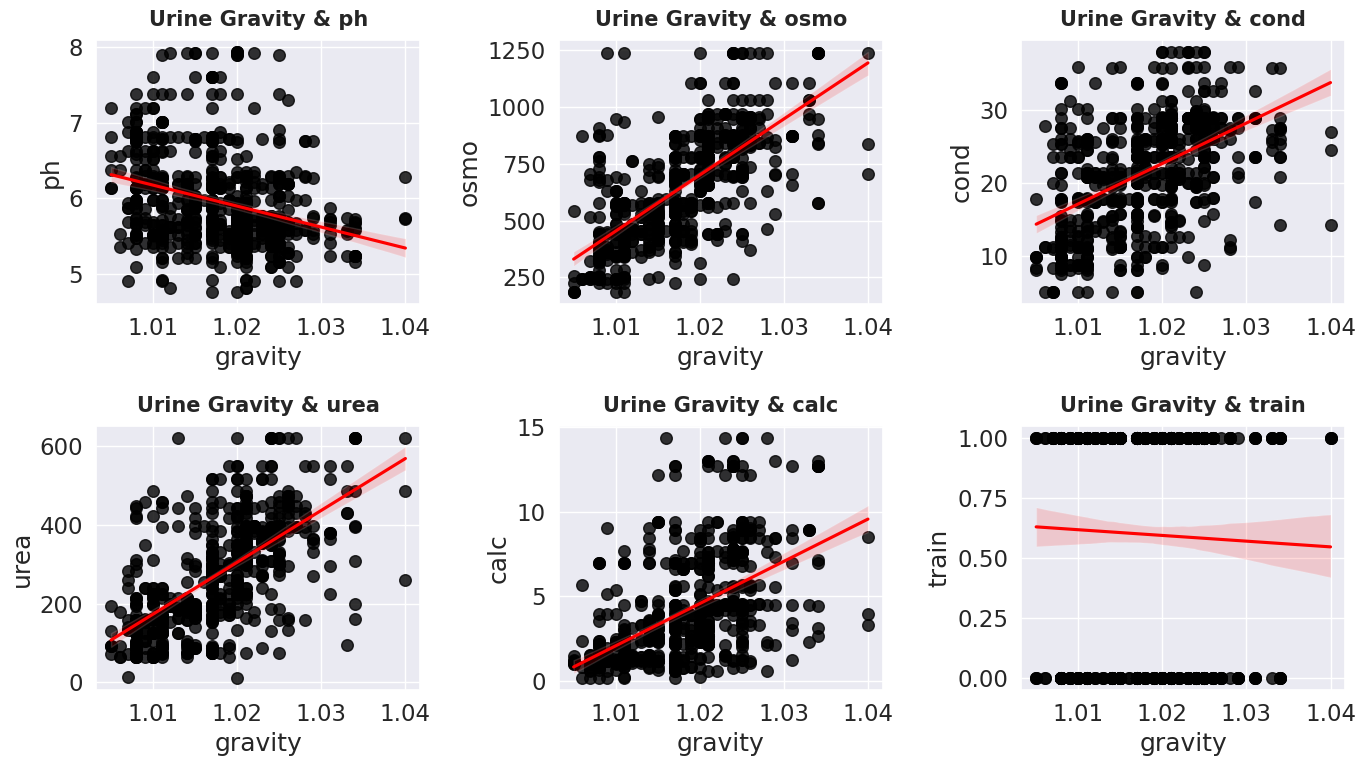

In [29]:
cols = df_train.columns.tolist()
cols.remove("gravity")
cols.remove("target")
plt.figure(figsize=(14,8))
for index,col in enumerate(cols):
    plt.subplot(2,3,index+1)
    sns.regplot(x="gravity",y=col,data=df,scatter_kws={'s': 70,"color":"black"}, line_kws={'color': 'red'})
    plt.title(f"Urine Gravity & {col}",fontweight="black",pad=10,size=15)
    plt.tight_layout()

* **Urea** & **Osmolality** feature are having **proper linear relation** with **Urine Gravity Feature.**
* With **increase in Urine Gravity the Urine PH decreases** so there's also a **linear relation among them.**


Findng Relation between Urine_PH w.r.t Other Features

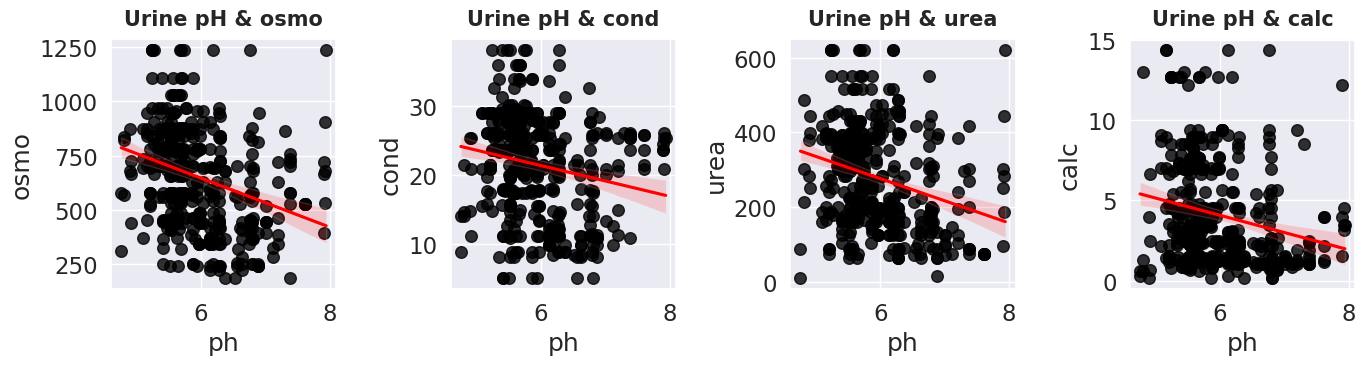

In [30]:
cols=["osmo","cond","urea","calc"]
plt.figure(figsize=(14,4))
for index,col in enumerate(cols):
    plt.subplot(1,4,index+1)
    sns.regplot(x="ph",y=col,data=df_train,scatter_kws={'s': 70,"color":"black"}, line_kws={'color': 'red'})
    plt.title(f"Urine pH & {col}",fontweight="black",pad=10,size=15)
    plt.tight_layout()

* **Urine pH** feature is having **litte relation with feature Osmolality & Urea.**
* Urine pH has no relation with Conductivity,Calcium


Findng Relation between Osmolality w.r.t Other Features

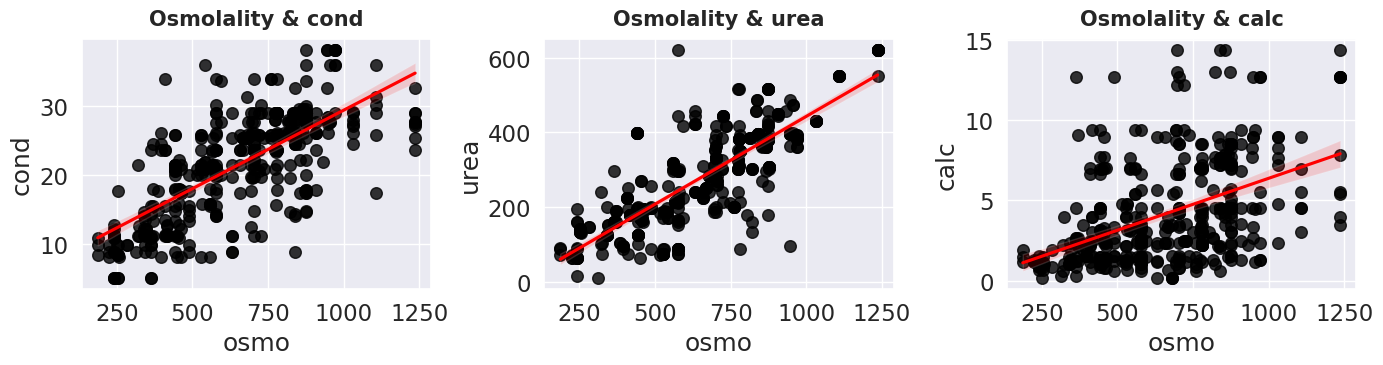

In [31]:
cols = ["cond","urea","calc"]
plt.figure(figsize=(14,4))
for index,col in enumerate(cols):
    plt.subplot(1,3,index+1)
    sns.regplot(x="osmo",y=col,data=df_train,scatter_kws={'s': 70,"color":"black"}, line_kws={'color': 'red'})
    plt.title(f"Osmolality & {col}",fontweight="black",pad=10,size=15)
    plt.tight_layout()

* Osmolality feature has strong linear relation with Conductivity, Urea, Calciumfeatures.
*  Osmolality is important feature

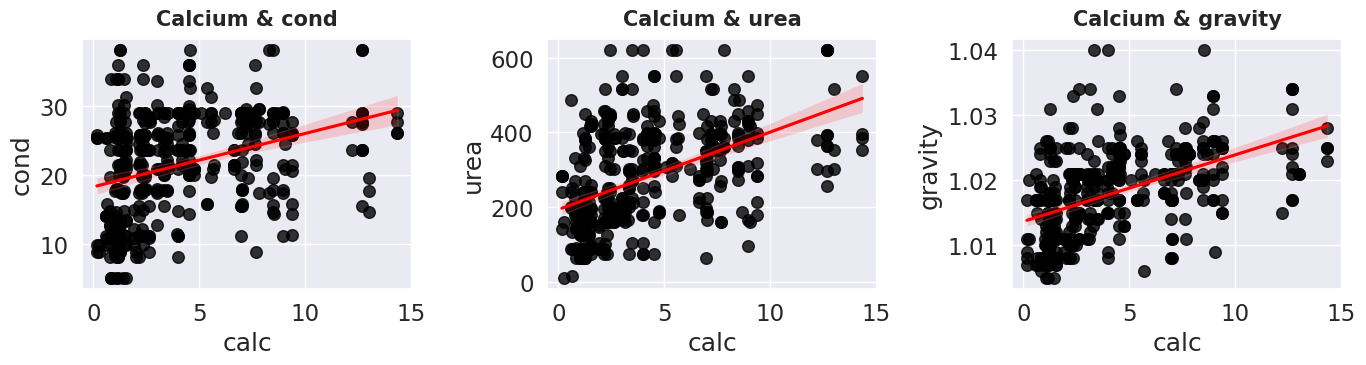

In [32]:
cols = ["cond","urea","gravity"]
plt.figure(figsize=(14,4))
for index,col in enumerate(cols):
    plt.subplot(1,3,index+1)
    sns.regplot(x="calc",y=col,data=df_train,scatter_kws={'s': 70,"color":"black"}, line_kws={'color': 'red'})
    plt.title(f"Calcium & {col}",fontweight="black",pad=10,size=15)
    plt.tight_layout()

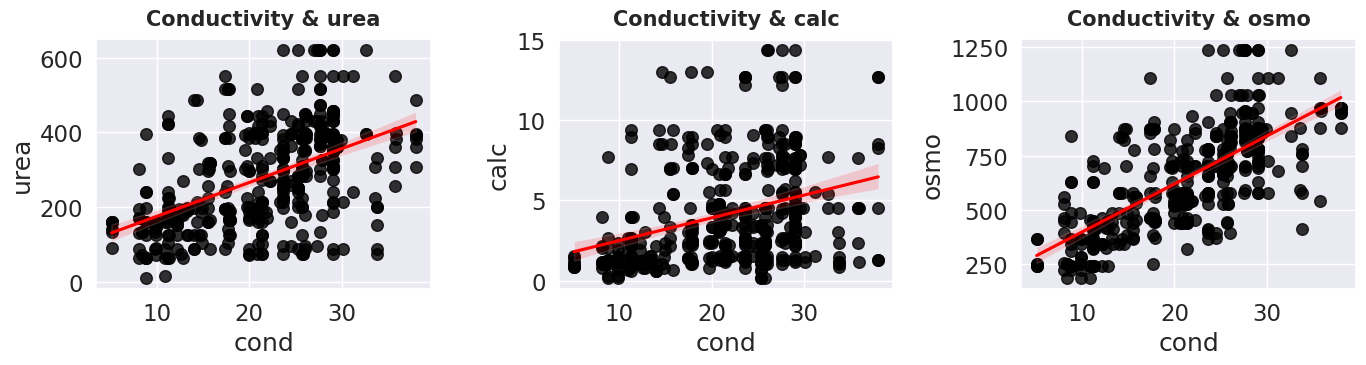

In [33]:
cols = ["urea","calc","osmo"]
plt.figure(figsize=(14,4))
for index,col in enumerate(cols):
    plt.subplot(1,3,index+1)
    sns.regplot(x="cond",y=col,data=df_train,scatter_kws={'s': 70,"color":"black"}, line_kws={'color': 'red'})
    plt.title(f"Conductivity & {col}",fontweight="black",pad=10,size=15)
    plt.tight_layout()

##Feature  Extraction



a. Statistical Summary: Calculates statistical measures such as count,mean, median, standard deviation, minimum, maximum for each clinical parameter.

b. Interaction Terms: Create interaction terms by combining pairs of clinical parameters. For example,gravity/ph

c. Normalization: Normalize the values of clinical parameters to ensure they are on a similar scale. This can be particularly important if the parameters have different units or ranges.

d. Feature Engineering: Engineer new features based on domain knowledge. For example, you could create a feature indicating the presence or absence of specific threshold levels for certain parameters.



#statistical summary

In [34]:
df_train.describe()

,gravity,ph,osmo,cond,urea,calc,train,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.0,414.000000
mean,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,1.0,0.444444
std,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.0,0.497505
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,1.0,0.000000
25%,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,1.0,0.000000
50%,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,1.0,0.000000
75%,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.0,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.0,1.000000


#interaction terms

In [35]:
df["gravity/ph"] = df["gravity"] / df["ph"] #HG,LP
df["gravity*osmo"] = df["gravity"] * df["osmo"] #veryhigh or verylow ==> average
df["gravity*ph"] = df["gravity"] * df["ph"] #LG,LP
df["gravity/calc"] = df["gravity"] / df["calc"]#inverse realtionship
df["osmo*urea"] = df["osmo"] * df["urea"] #average or low values
df["ph*osmo"] = df["ph"] * df["osmo"]
df["cond_urea_ph"] = df["cond"] * df["urea"] / df["ph"]
df["cond*calc"] = df["cond"] * df["calc"]
df["osmo/cond"] = df["osmo"] / df["cond"] #HO,LC
df["gr_osmo_cal"] = df["gravity"] * df["osmo"] / df["calc"]
# Osmolality feature has strong linear relation with Conductivity, Urea, Calcium


In [36]:
columns = df.columns.tolist()
columns.remove("train")
columns.remove("target")

#features have varying scales  so to ensure that the magnitude of each sample's representation is consistent,we are going for normalization

In [37]:
data_norm = preprocessing.normalize(df[columns], axis=0)
df_norm = pd.DataFrame(data_norm, columns = columns)
print(df_norm)

      gravity        ph      osmo      cond      urea      calc  gravity/ph  \
0    0.037879  0.039393  0.024304  0.024645  0.015191  0.010662    0.035852   
1    0.038328  0.034365  0.038569  0.039298  0.048268  0.030736    0.041584   
2    0.037729  0.039011  0.020354  0.040797  0.019479  0.066471    0.036060   
3    0.038178  0.031247  0.024250  0.034636  0.048758  0.048751    0.045555   
4    0.038178  0.035193  0.047951  0.029640  0.047166  0.016250    0.040448   
..        ...       ...       ...       ...       ...       ...         ...   
685  0.038477  0.039902  0.046798  0.035635  0.044593  0.053751    0.035953   
686  0.037842  0.035766  0.022494  0.023313  0.023889  0.010662    0.039449   
687  0.038552  0.036147  0.047951  0.048290  0.046553  0.033015    0.039765   
688  0.038103  0.034811  0.029791  0.035635  0.020826  0.012059    0.040811   
689  0.038029  0.039393  0.038295  0.048290  0.030872  0.025956    0.035993   

     gravity*osmo  gravity*ph  gravity/calc  osmo*u

In [38]:
df_norm.reset_index(drop = True, inplace = True)#reset the index of two DataFrames, df_norm and df
df.reset_index(drop = True, inplace = True)#discards the current index and replaces it with a default integer index

In [39]:
df_norm["train"], df_norm["target"] = df["train"], df["target"]

##Feature Engineering

In [40]:
features = ['gravity/ph', 'osmo/cond', 'gravity*ph', 'gravity*osmo', 'osmo*urea',
            'cond_urea_ph', 'ph*osmo', 'gravity/calc','gr_osmo_cal']

In [41]:
X = df_norm[df_norm["train"] == 1][features].copy()
y = df_norm[df_norm["train"] == 1]["target"].copy()
print(X.shape, y.shape)

(414, 9) (414,)


In [42]:
df_norm

,gravity,ph,osmo,cond,urea,calc,gravity/ph,gravity*osmo,gravity*ph,gravity/calc,osmo*urea,ph*osmo,cond_urea_ph,cond*calc,osmo/cond,gr_osmo_cal,train,target
0,0.037879,0.039393,0.024304,0.024645,0.015191,0.010662,0.035852,0.024113,0.039212,0.032595,0.007977,0.025670,0.008174,0.006233,0.034219,0.026319,1,0.0
1,0.038328,0.034365,0.038569,0.039298,0.048268,0.030736,0.041584,0.038719,0.034613,0.011441,0.040224,0.035537,0.047475,0.028652,0.034054,0.014660,1,0.0
2,0.037729,0.039011,0.020354,0.040797,0.019479,0.066471,0.036060,0.020114,0.038679,0.005208,0.008567,0.021290,0.017521,0.064328,0.017311,0.003521,1,0.0
3,0.038178,0.031247,0.024250,0.034636,0.048758,0.048751,0.045555,0.024249,0.031349,0.007185,0.025547,0.020316,0.046485,0.040054,0.024293,0.005788,1,1.0
4,0.038178,0.035193,0.047951,0.029640,0.047166,0.016250,0.040448,0.047949,0.035308,0.021555,0.048866,0.045245,0.034167,0.011426,0.056133,0.034338,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.038477,0.039902,0.046798,0.035635,0.044593,0.053751,0.035953,0.047164,0.040346,0.006568,0.045091,0.050067,0.034253,0.045436,0.045568,0.010211,0,NaN
686,0.037842,0.035766,0.022494,0.023313,0.023889,0.010662,0.039449,0.022295,0.035566,0.032563,0.011611,0.021570,0.013393,0.005896,0.033480,0.024335,0,NaN
687,0.038552,0.036147,0.047951,0.048290,0.046553,0.033015,0.039765,0.048419,0.036621,0.010713,0.048232,0.046473,0.053491,0.037819,0.034454,0.017067,0,NaN
688,0.038103,0.034811,0.029791,0.035635,0.020826,0.012059,0.040811,0.029732,0.034856,0.028989,0.013406,0.027805,0.018337,0.010193,0.029008,0.028692,0,NaN


In [43]:
df_norm.describe()

,gravity,ph,osmo,cond,urea,calc,gravity/ph,gravity*osmo,gravity*ph,gravity/calc,osmo*urea,ph*osmo,cond_urea_ph,cond*calc,osmo/cond,gr_osmo_cal,train,target
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,414.000000
mean,0.038069,0.037859,0.035819,0.035997,0.034252,0.030144,0.037883,0.035774,0.037866,0.023422,0.030255,0.035948,0.031262,0.028202,0.036129,0.023679,0.600000,0.444444
std,0.000248,0.003997,0.012903,0.012398,0.016628,0.023268,0.003763,0.013029,0.003929,0.030033,0.023124,0.012540,0.021740,0.025590,0.012007,0.029831,0.490253,0.497505
min,0.037580,0.030292,0.010259,0.008492,0.001225,0.001250,0.027993,0.010098,0.030273,0.003306,0.000453,0.010342,0.000510,0.000435,0.013867,0.002483,0.000000,0.000000
25%,0.037851,0.035193,0.025018,0.026310,0.020826,0.010754,0.035649,0.024870,0.035290,0.008415,0.010860,0.025743,0.012016,0.008164,0.029282,0.010451,0.000000,0.000000
50%,0.038066,0.036466,0.036649,0.036967,0.034547,0.023236,0.038923,0.036612,0.036639,0.014986,0.025547,0.036445,0.028440,0.020634,0.033782,0.017131,1.000000,0.000000
75%,0.038253,0.039902,0.046085,0.045959,0.047166,0.041692,0.040448,0.046264,0.039757,0.032402,0.045567,0.044905,0.047133,0.039564,0.039861,0.026603,1.000000,1.000000
max,0.038889,0.050530,0.067811,0.063277,0.075955,0.105443,0.046945,0.069071,0.050646,0.279113,0.111288,0.091871,0.105742,0.139948,0.125305,0.345946,1.000000,1.000000


In [44]:
alldt = df_norm.copy()  #this is now new dataframe
alldt2 = alldt.copy() #any modifications made to alldt do not affect the original DataFrame df_norm
alldt = alldt.iloc[:, :-1] #removes the target value
alldt

,gravity,ph,osmo,cond,urea,calc,gravity/ph,gravity*osmo,gravity*ph,gravity/calc,osmo*urea,ph*osmo,cond_urea_ph,cond*calc,osmo/cond,gr_osmo_cal,train
0,0.037879,0.039393,0.024304,0.024645,0.015191,0.010662,0.035852,0.024113,0.039212,0.032595,0.007977,0.025670,0.008174,0.006233,0.034219,0.026319,1
1,0.038328,0.034365,0.038569,0.039298,0.048268,0.030736,0.041584,0.038719,0.034613,0.011441,0.040224,0.035537,0.047475,0.028652,0.034054,0.014660,1
2,0.037729,0.039011,0.020354,0.040797,0.019479,0.066471,0.036060,0.020114,0.038679,0.005208,0.008567,0.021290,0.017521,0.064328,0.017311,0.003521,1
3,0.038178,0.031247,0.024250,0.034636,0.048758,0.048751,0.045555,0.024249,0.031349,0.007185,0.025547,0.020316,0.046485,0.040054,0.024293,0.005788,1
4,0.038178,0.035193,0.047951,0.029640,0.047166,0.016250,0.040448,0.047949,0.035308,0.021555,0.048866,0.045245,0.034167,0.011426,0.056133,0.034338,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.038477,0.039902,0.046798,0.035635,0.044593,0.053751,0.035953,0.047164,0.040346,0.006568,0.045091,0.050067,0.034253,0.045436,0.045568,0.010211,0
686,0.037842,0.035766,0.022494,0.023313,0.023889,0.010662,0.039449,0.022295,0.035566,0.032563,0.011611,0.021570,0.013393,0.005896,0.033480,0.024335,0
687,0.038552,0.036147,0.047951,0.048290,0.046553,0.033015,0.039765,0.048419,0.036621,0.010713,0.048232,0.046473,0.053491,0.037819,0.034454,0.017067,0
688,0.038103,0.034811,0.029791,0.035635,0.020826,0.012059,0.040811,0.029732,0.034856,0.028989,0.013406,0.027805,0.018337,0.010193,0.029008,0.028692,0


#The ROC AUC score ranges from 0 to 1, where 0 represents a poor model (classifies all instances incorrectly) and 1 represents a perfect model (classifies all instances correctly).

calculating the ROC AUC score by comparing the true labels y_val (the ground truth) against the predicted probabilities ensemble_preds (the output of our ensemble model) for validation set.

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier

X = alldt[alldt["train"] == 1].copy()
y = alldt2[alldt2["train"] == 1]["target"].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 121)
X_train, y_train = X, y
ada_clf = AdaBoostClassifier(n_estimators=150, learning_rate=1.0)  # You can adjust parameters as needed
ada_clf.fit(X_train, y_train)
xbc_model = XGBClassifier(n_estimators = 140, learning_rate = 0.05, max_depth = 5,
                          eval_metric = "auc", booster = 'gbtree')
xbc_model.fit(X_train, y_train)
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)  # Adjust parameters as needed
lgb_model.fit(X_train, y_train)

# Predictions for Adaboost Classifier
ada_preds = ada_clf.predict(X_val)  #to create a strong classifier.
# Predictions for XGBoost Classifier
xgb_preds = xbc_model.predict(X_val)
# Predictions for LightGBM Classifier
lgb_preds = lgb_model.predict(X_val)

# Define classifiers
classifiers = [
    ("AdaBoost Classifier", AdaBoostClassifier(n_estimators=150, learning_rate=1.0)),

    #("XGBoost Classifier", XGBClassifier(n_estimators=300, learning_rate=0.01, max_depth=5, min_child_weight=1, gamma=0.1, eval_metric="auc", booster='gbtree', reg_alpha=0.1, reg_lambda=0.1)),
    ("XGBoost Classifier", XGBClassifier(n_estimators=140, learning_rate=0.05, max_depth=5, eval_metric="auc", booster='gbtree')),
    ("LightGBM Classifier", lgb.LGBMClassifier(n_estimators=140, max_depth=5, learning_rate=0.07,num_leaves=29))
    #("LightGBM Classifier", lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.01, num_leaves=31, min_child_samples=20))

]

# Evaluate each classifier
for clf_name, clf_model in classifiers:
    clf_model.fit(X_train, y_train)
    clf_preds = clf_model.predict(X_val)

    # Print classification report and confusion matrix
    print(f"{clf_name}:")
    print(classification_report(y_val, clf_preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, clf_preds))

    # Calculate and print additional evaluation metrics
    clf_accuracy = accuracy_score(y_val, clf_preds)
    clf_precision = precision_score(y_val, clf_preds)
    clf_recall = recall_score(y_val, clf_preds)
    clf_f1 = f1_score(y_val, clf_preds)
    print("\nAdditional Evaluation Metrics:")
    print(f"Accuracy: {clf_accuracy:.4f}")
    print(f"Precision: {clf_precision:.4f}")
    print(f"Recall: {clf_recall:.4f}")
    print(f"F1-score: {clf_f1:.4f}\n")

# ROC AUC score for the ensemble
ensemble_preds = (0.33 * ada_preds  + 0.33 * xgb_preds + 0.33 * lgb_preds)
ensemble_score = roc_auc_score(y_val, ensemble_preds)
print("\nEnsemble ROC AUC Score:", ensemble_score)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 184, number of negative: 230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1661
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

Adaboost
1.Improved Accuracy
2.strong classifier
3.Automatic Feature Selection
4.less prone to overfitting
5.Fewer Hyperparameters